In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from source import data_import
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES

print(f"loaded channel names: {CHANNELS}")

loaded channel names: ['F4-C4', 'F3-C3', 'FT9-FT10', 'FZ-CZ', 'F7-T7', 'FP2-F4', 'T8-P8-1', 'T8-P8-0', 'FP1-F3', 'CZ-PZ']


In [49]:
# load data
df_pp = data_import.load_pyarrow(file_name="preprocessed_seg")
df_pp.shape

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/preprocessed_seg.arrow was loaded.


(8102400, 18)

In [50]:
test= df_pp.drop(['file','target'],axis=1)
missing_data = np.isnan(test)
missing_count = missing_data.sum()

# Display the count of missing values
print(missing_count)

channel
F4-C4             0
F3-C3             0
FT9-FT10          0
FZ-CZ             0
F7-T7             0
FP2-F4            0
T8-P8-1           0
T8-P8-0           0
FP1-F3            0
CZ-PZ             0
before_seizure    0
is_seizure        0
epoch             0
segment_id        0
seizure_start     0
seizure_id        0
dtype: int64


In [145]:
# df_pp = df_pp.iloc[:2_000_000,:]
# df_pp.shape

## Feature Extraction

In [51]:
# ignore for aggregation
ignore_col = []

# target definition
PRED_INTERVAL = 60
target_colname = 'target'

In [52]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval


In [53]:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

In [54]:
df_features = df_pp.groupby(['epoch', 'segment_id']).agg(
    {C:[
        # 'mean', 
        'std',
        'var',
        'mean',
        abs_mean_agg,
        delta_agg,
        theta_agg,
        gamma_agg
        ] for C in CHANNELS} | 
    {target_colname: [target_foo]} 
    ) 
df_features.head()

channel               F4-C4                                               \
                        std         var      mean   abs_mean       delta   
epoch segment_id                                                           
0     0           19.215291  369.227396  1.677760  14.539727   39.509423   
      1           19.292719  372.208995 -0.391839  15.081409   57.166882   
      2           26.026211  677.363658  1.356797  18.727514  112.603482   
      3           26.999490  728.972443 -1.657887  18.877600  148.551723   
      4           23.273241  541.643731  0.776272  17.412866   77.372989   

channel                                    F3-C3                        ...  \
                      theta     gamma        std         var      mean  ...   
epoch segment_id                                                        ...   
0     0           15.649456  1.143016  21.315638  454.356435  1.053339  ...   
      1           13.481116  1.218430  25.477037  649.079429  0.811962  ...   
      2           22.111449  0.943441  27.729263  768.912015  1.282874  ...   
      3           15.161321  1.178056  29.614908  877.042781 -2.174102  ...   
      4           25.561364  1.423834  23.413506  548.192254  0.848064  ...   

channel               FP1-F3                 CZ-PZ                        \
                       theta      gamma        std         var      mean   
epoch segment_id                                                           
0     0            92.822474  22.441816  16.368013  267.911860  0.692305   
      1            76.808250  33.427544  18.012047  324.433840 -0.487618   
      2           176.024973   8.914849  22.813508  520.456131  1.294472   
      3            75.730101  21.215121  19.942794  397.715029 -0.476040   
      4           284.475569  16.303152  18.725786  350.655046  1.382429   

channel                                                       target  
                   abs_mean      delta      theta     gamma <lambda>  
epoch segment_id                                                      
0     0           13.053429  33.181709  18.606278  0.272641    False  
      1           14.154003  40.078259  21.722061  0.268936    False  
      2           18.522101  78.066994  19.695134  0.256728    False  
      3           15.324033  60.340596  18.821070  0.258679    False  
      4           15.186356  46.083693  24.182717  0.271254    False  

[5 rows x 71 columns]

## Flatten Dataframe

In [55]:
# joining column names with agg functions, but leaving target column
df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
df_features.reset_index(inplace=True)
df_features.tail(10)


,epoch,segment_id,F4-C4_std,F4-C4_var,F4-C4_mean,F4-C4_abs_mean,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_std,...,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_std,CZ-PZ_var,CZ-PZ_mean,CZ-PZ_abs_mean,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma,target
6320,210,20,19.913137,396.533035,1.814359,15.844688,27.337306,10.821152,2.875053,16.531111,...,11.887165,4.310094,19.561364,382.646953,-1.812724,15.515349,35.583552,29.009580,0.310722,True
6321,210,21,16.371755,268.034372,0.409629,12.894569,11.812878,9.683788,2.266294,14.478987,...,21.295310,4.087869,17.916115,320.987190,-1.163153,14.306836,32.987609,30.517079,0.338506,True
6322,210,22,21.814065,475.853411,0.924962,14.579394,81.037168,17.978513,1.345281,23.693531,...,314.455854,4.283704,21.400060,457.962550,1.104418,16.518391,44.082129,26.356893,0.332920,True
6323,210,23,39.315795,1545.731704,0.477843,26.660220,237.500875,42.817023,4.640500,59.936462,...,498.395659,11.697668,46.964725,2205.685430,-0.477186,32.935044,243.005207,95.427750,2.101212,True
6324,210,24,21.907242,479.927253,-2.058955,16.046209,19.696241,14.424503,5.732749,20.158522,...,21.517362,5.847130,23.230786,539.669427,-0.078214,17.954194,50.463447,42.055752,0.283099,True
6325,210,25,15.295551,233.953871,0.606307,12.137530,17.399332,9.376133,1.298093,13.865905,...,18.401002,3.354048,17.588980,309.372232,0.553462,13.918196,36.699093,20.016858,0.316210,True
6326,210,26,29.448778,867.230525,0.009972,19.600868,123.699358,31.947971,4.304505,24.104124,...,643.877202,7.375571,17.413913,303.244369,0.056325,13.545334,35.646023,16.537984,0.362234,True
6327,210,27,26.389943,696.429104,1.164168,17.922418,113.515023,22.874433,1.661236,16.088811,...,22.915704,4.287799,19.967625,398.706037,0.716974,14.774465,39.760362,29.065103,0.290968,True
6328,210,28,25.568161,653.730840,-0.899313,18.904056,78.114853,32.881236,1.504684,21.065670,...,268.996766,4.620775,22.137329,490.061349,0.068963,17.288573,34.773472,44.761102,0.256079,True
6329,210,29,73.924512,5464.833416,1.185509,50.223953,1136.387393,120.699210,3.541596,88.100741,...,921.680345,5.590974,73.844680,5453.036835,2.091256,49.570092,796.357145,66.704948,0.477306,True


In [99]:
#Preparing data to be scaled

num_features= df_features.drop(['epoch','segment_id','target'],axis =1)

from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

scaler = StandardScaler()
num_features_scaled = scaler.fit_transform(num_features)

/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767

In [100]:
original_array =np.array(df_features)
target=original_array[:,-1]
target = target[:, np.newaxis]
segseiz_column = original_array[:, 0:2] ## epoch and segment_id
array_all_scaled = np.concatenate((segseiz_column, num_features_scaled, target), axis=1)
array_all_scaled.shape

(6330, 73)

In [10]:
# # Determine the number of epochs
# num_epochs = df_features.epoch.nunique()
# # # Determine the number of segments for each epoch
# num_segments = df_features.segment_id.nunique()  # Assuming there are 30 segments for each epocha
# num_features = array_all_scaled.shape[1]

# reshaped_all= array_all_scaled.reshape(num_epochs, num_segments, num_features)
# reshaped_all.shape

(77, 30, 73)

In [101]:
import numpy as np


original_array =np.array(df_features)

# Extract the epoch column
epoch_column = original_array[:, 0]

# Determine the number of epochs (assuming epochs are from 1 to number of segments)
num_epochs = df_features.epoch.unique()[-1]

# Determine the number of segments for each epoch
num_segments = len(df_features.segment_id.unique())  # Assuming there are 30 segments for each epoch

# Initialize an empty 3D array
reshaped_array = np.empty((num_epochs,num_segments, array_all_scaled.shape[1]))

# Reshape the data for each epoch and insert it into the 3D array
for epoch in range(num_epochs):
    start_idx = epoch * num_segments
    end_idx = (epoch + 1) * num_segments
    reshaped_array[epoch,:, :] = array_all_scaled[start_idx:end_idx,:]

In [72]:
reshaped_array.shape

(210, 30, 73)

In [110]:
data =reshaped_array[35,:,2:-1]

In [93]:
data.shape
test=pd.DataFrame(data)
test.head(20)

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,2.514575,1.956651,-0.030624,2.802255,3.087126,0.289857,-0.228688,1.239281,0.763741,-0.604829,...,0.435275,0.346808,-0.354423,2.284590,1.237133,1.264310,2.700628,1.665769,0.247785,-0.144072
1,1.749058,1.102110,-3.584772,1.899930,1.170017,0.299217,-0.233397,1.525528,1.077864,-2.844309,...,-0.045068,-0.208751,-0.355701,1.560280,0.663586,0.140039,1.844579,0.927828,0.136885,-0.144071
2,1.567090,0.926141,1.442635,1.863238,0.941451,0.231885,-0.228414,0.954638,0.484896,1.834457,...,0.061351,0.065131,-0.354636,1.513180,0.630842,-0.478941,1.795783,1.040249,0.082035,-0.140350
3,1.077661,0.504608,1.556869,1.269746,0.664602,-0.110506,-0.230938,0.917221,0.450728,0.848517,...,-0.174194,-0.265200,-0.353678,0.971669,0.294321,0.404141,1.180394,0.463326,-0.056226,-0.138168
4,1.482656,0.848033,-0.190330,1.778538,0.729819,0.053519,-0.222030,0.832734,0.375699,-1.515061,...,0.175848,0.037551,-0.355151,1.494916,0.618294,-0.161646,1.934845,0.882485,-0.024881,-0.138032
5,1.982169,1.342780,-4.846751,2.517589,1.667779,-0.140413,-0.223815,1.322056,0.851103,-0.974750,...,-0.066412,-0.094301,-0.353227,1.082723,0.357345,-0.066039,1.365227,0.628098,-0.011351,-0.141744
6,1.781302,1.134380,3.083578,2.071524,1.526716,0.265204,-0.228020,1.245015,0.769701,1.913668,...,0.486570,0.271777,-0.353570,1.617247,0.703932,0.899445,1.961219,0.718695,0.122544,-0.136457
7,0.754583,0.267699,2.038131,0.995313,0.306615,0.231864,-0.233038,0.827085,0.370787,-0.987529,...,-0.301825,0.029913,-0.354002,1.397685,0.552903,-1.428084,1.781418,0.914543,0.080981,-0.140315
8,1.288151,0.676648,0.434640,1.445870,0.884495,0.301912,-0.233258,1.457033,0.999622,1.906801,...,0.184928,0.177244,-0.349290,1.874240,0.896053,-0.069256,1.847332,1.171391,0.204956,-0.142564
9,1.787017,1.140134,-2.306052,2.207287,1.044542,0.785193,-0.233756,0.735625,0.293098,-1.385614,...,0.907439,0.043414,-0.354727,1.978735,0.978904,1.004218,2.492755,1.399140,0.330853,-0.146244


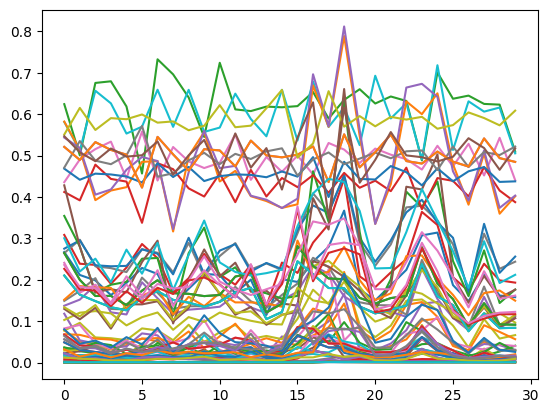

In [111]:
plt.plot(data)

In [85]:

np.save('data/feature_extract_reshaped.npy', reshaped_array)

In [26]:
# from source.data_import import save_pyarrow

# save_pyarrow(df_features, file_name="feature_extracted")

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/feature_extracted.arrow was successfully written.
